# Pythagorean Triples via Grover's Algorithm
##### Elijah Kin
Here we attempt to generate Pythagorean triples on a quantum computer by means of Grover's algorithm.

In [1]:
import qiskit

from qiskit import transpile, QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.circuit.library import MultiplierGate, HalfAdderGate
from qiskit.visualization import plot_histogram

In [2]:
print(qiskit.__version__)

# backend = Aer.get_backend('aer_simulator')
backend = Aer.get_backend('aer_simulator_matrix_product_state')

1.3.2


### Squaring a Register
We will first design a circuit which sends $|a\rangle |0\rangle \mapsto |a\rangle |a^2\rangle$.

In [3]:
# Create circuit for squaring a
def SquareGate(n):
  qc = QuantumCircuit(4 * n)
  # Probably not the most efficient way to do this...
  qc.cx(range(n), range(n, 2 * n))
  return qc.compose(MultiplierGate(n))

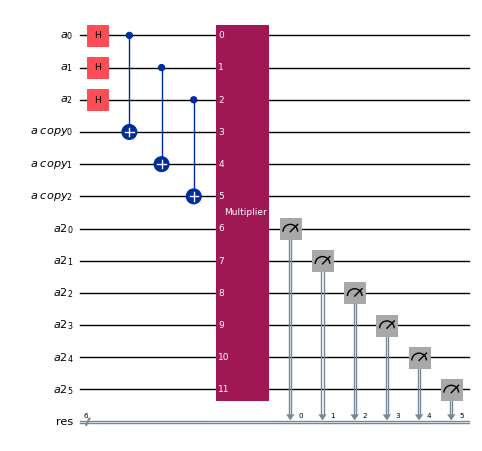

In [4]:
n = 3
qr_a = QuantumRegister(n, name='a')
ar_a = AncillaRegister(n, name='a copy')
qr_a2 = QuantumRegister(2 * n, name='a2')
cr_a2 = ClassicalRegister(2 * n, name='res')

qc = QuantumCircuit(qr_a, ar_a, qr_a2, cr_a2)
qc.h(qr_a)
qc.compose(SquareGate(len(qr_a)), inplace=True)
qc.measure(qr_a2, cr_a2)

qc.draw('mpl', scale=0.5)

In [5]:
qc_opt = transpile(qc, backend=backend, optimization_level=2)

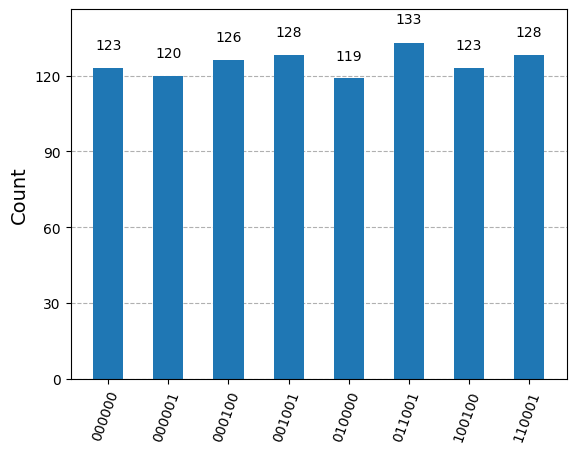

In [6]:
results = backend.run(qc_opt, shots=1000).result()
plot_histogram(results.get_counts())

We see that the above indeed works; the measured states correspond exactly to the perfect squares: $0, 1, 4, 9, 16, 25, 36, 49$

### Designing the Oracle

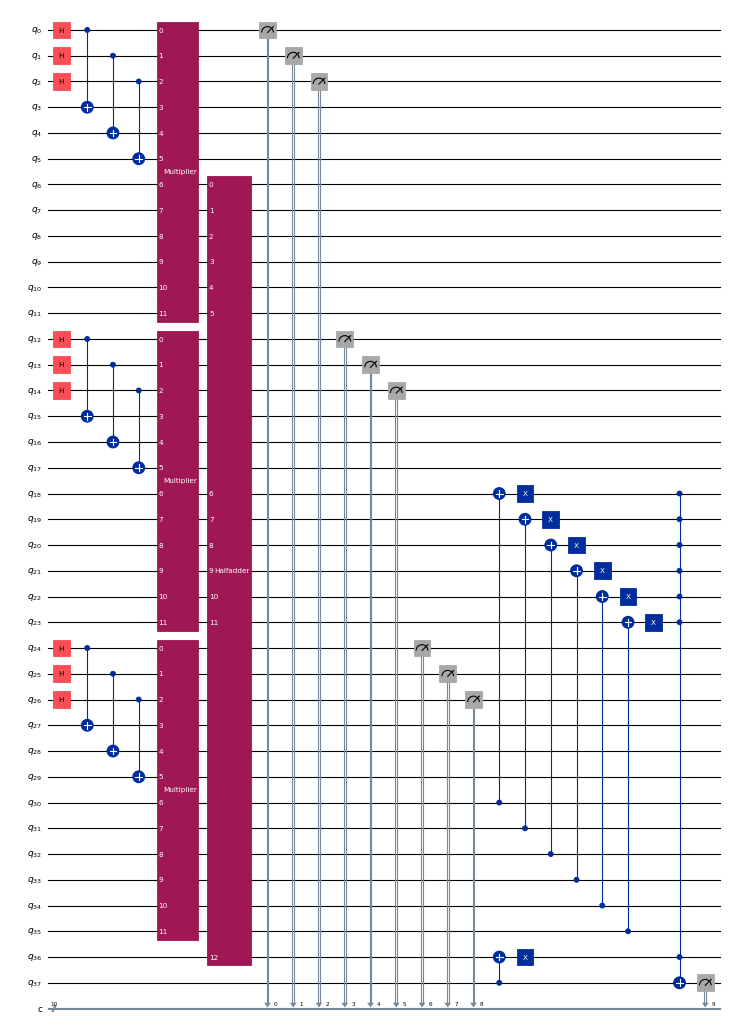

In [7]:
# Create the Grover oracle for Pythagorean search where n specify numbers of bits for a, b, c
def grover_oracle(n):
  # Needs 4n qubits to compute each square
  qc = QuantumCircuit(12 * n + 2, 10)

  qc.h([0, 1, 2])
  qc.h([12, 13, 14])
  qc.h([24, 25, 26])
  # qc.barrier()

  # Compute the squares a^2, b^2, and c^2
  qc.compose(SquareGate(n), qubits=range(0, 4 * n), inplace=True)
  qc.compose(SquareGate(n), qubits=range(4 * n, 2 * 4 * n), inplace=True)
  qc.compose(SquareGate(n), qubits=range(2 * 4 * n, 3 * 4 * n), inplace=True)

  # Add a^2 and b^2
  qc.compose(HalfAdderGate(2 * n), qubits=[6, 7, 8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 36], inplace=True)
  # qc.barrier()

  # Check if each qubit of a^2 + b^2 and c^2 are equal
  # TODO
  qc.cx([30, 31, 32, 33, 34, 35, 37], [18, 19, 20, 21, 22, 23, 36])
  qc.x([18, 19, 20, 21, 22, 23, 36])
  # qc.barrier()

  # Sandwich to convert bit-flip oracle to phase-flip oracle
  # qc.x(37)
  # qc.h(37)

  # MCX on all equality qubits
  qc.mcx([18, 19, 20, 21, 22, 23, 36], 37)

  # qc.h(37)
  # qc.x(37)

  return qc

oracle = grover_oracle(3)
# oracle.barrier()
oracle.measure([0, 1, 2, 12, 13, 14, 24, 25, 26, 37], range(10))
# oracle.measure(37, 0)

oracle.draw('mpl', fold=-1, scale=0.4)

In [8]:
oracle_opt = transpile(oracle, backend=backend, optimization_level=2)

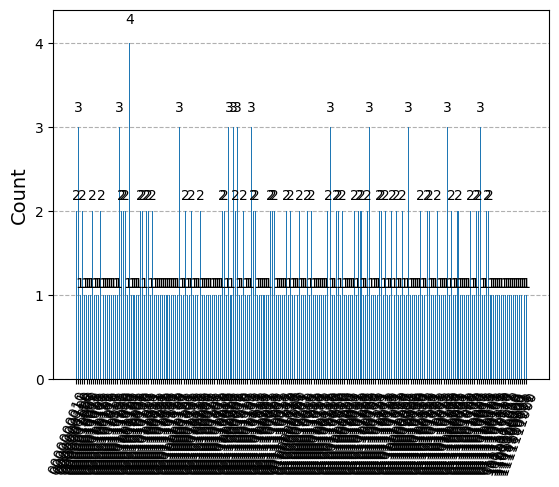

In [9]:
results = backend.run(oracle_opt, shots=300).result()
plot_histogram(results.get_counts())

In [10]:
for key in results.get_counts().keys():
  if key[0] == '1':
    triple = ''
    for i in range(1, len(key), 3):
      triple += str(int(key[i : i + 3], base=2))
      triple += ' '
    print(triple)

1 1 0 
4 4 0 
6 6 0 
5 0 5 
5 4 3 
7 7 0 
7 0 7 
2 2 0 


We see that we correctly implement the check for Pythagorean triples.

### Implementing Grover's Algorithm

In [11]:
# TODO